# Liquidity analysis

This is an example how to analyse [Automated Market Market liquidity](../glossary.html#AMM) on a blockchain. It is similar of order book depth analysis on centralised exchanges.

We will

* Download pair and exchange map ("the trading universe")

* Plot a liquidity of a single trading pair on SushiSwap

* Compare the historical liquidity of all pairs on SushiSwap and Uniswap v2

* Calculate the slippage for a hypotethical trade that would have happened at a specific timepoint

## About liquidity data collection on AMM exchanges

Capitalgram maintains the data of Uniswap v2 style, x*y = k bonding curve, liquidity in a similar format as it maintains OHLC price data. In more traditional finance, the equivalent analysis would be an order book depth - how much you can buy or sell and how much it would move the price.

For each [time bucket](../api/glossary.html#bucket) you get the available liquidity

* At open (start of the time bucket period)

* At close (end  of the time bucket period)

* At peak (high of the time bucket period)

* At bottom (low of the time bucket period)

The liquidity is expressed as the US dollar depth of the one side of the pool. E.g. the liquidity of a pool with 50 USDC and 0.001 ETH would be 50 USD.

There is also something very swap liquidity pool specific measurements

* Added and removed liquidity, as volume and as number of transactions

The liquidity data can be very effectively used to analyse or predict the trading fees of a swap.

[Read API documentation](../api/liquidity.html)

## Getting started

First let's import libraries and initialise our dataset client.

In [5]:
try:
    import capitalgram
except ImportError:
    !pip install -e git+https://github.com/miohtama/capitalgram-onchain-dex-quant-data.git#egg=capitalgram
    import site
    site.main()

from capitalgram.client import Capitalgram

client = Capitalgram.create_jupyter_client()

Started Capitalgram in Jupyter notebook environment, configuration is stored in /Users/mikkoohtamaa/.capitalgram


Get the map of exchanges and pairs we are working on

In [6]:
from capitalgram.exchange import ExchangeUniverse
from capitalgram.pair import PandasPairUniverse
from capitalgram.timebucket import TimeBucket
from capitalgram.liquidity import GroupedLiquidityUniverse
from pyarrow import Table

# Exchange map data is so small it does not need any decompression
exchange_universe: ExchangeUniverse = client.fetch_exchange_universe()

# Fetch all trading pairs across all exchanges
pair_table: Table = client.fetch_pair_universe()
pair_universe = PandasPairUniverse(pair_table.to_pandas())

# Decompress the pair dataset to Python map
liquidity_table: Table = client.fetch_all_liquidity_samples(TimeBucket.d1)
liquidity_universe = GroupedLiquidityUniverse(liquidity_table.to_pandas())

## Single pair liquidity

Here we first narrow down our data to single trading

In [7]:
from capitalgram.chain import ChainId
from capitalgram.pair import DEXPair

# Filter down to pairs that only trade on Sushiswap
sushi_swap = exchange_universe.get_by_name_and_chain(ChainId.ethereum, "sushiswap")

pair: DEXPair = pair_universe.get_one_pair_from_pandas_universe(
    sushi_swap.exchange_id,
    "SUSHI",
    "USDT")

sushi_usdt_liquidity = liquidity_universe.get_liquidity_by_pair(pair.pair_id)

Now, let's plot how the liquidity has developed over the time. For OHLC liquidity values, we use high (peak) liquidity.

<AxesSubplot:title={'center':'SUSHI-USDT liquidity on SushiSwap, all-time'}, xlabel='Day', ylabel='Liquidity (millions of  dollars)'>

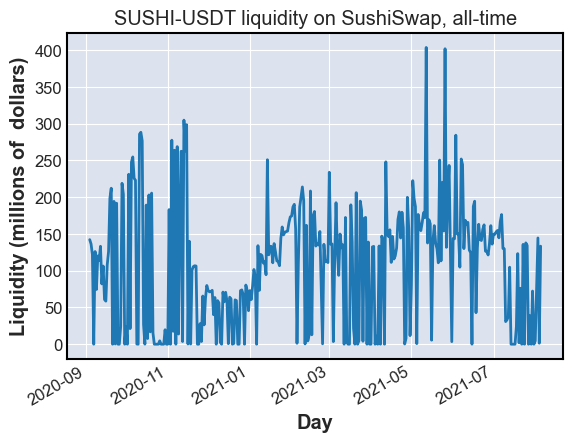

In [13]:
import pandas as pd

# Create a 2 dimensional data set for plotting
series = pd.Series(sushi_usdt_liquidity["high"], index=sushi_usdt_liquidity["timestamp"])

# Scale or data to milions of dollars
series = series / 1_000_000

axes_subplot = series.plot(title="SUSHI-USDT liquidity on SushiSwap, all-time")
axes_subplot.set_xlabel("Day")
axes_subplot.set_ylabel("Liquidity (millions of  dollars)")

axes_subplot

